In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from matplotlib.cm import ScalarMappable
from matplotlib import gridspec
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import pickle
import json
import os
import shutil
import sys
sys.path.append("..")

from main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#C70000FF"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"


In [2]:
randomSeed = 10
phaseLags = [0.6 * np.pi]
strengthKs = np.linspace(1, 39, 37)
distanceD0s = [0.1]  # 0.1, 0.25
omegaMins = [0]
deltaOmegas = [0]

models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        boundaryLength=7, speedV=3,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=5000, 
        dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

lastStateSavePath = r"F:\MS_ExperimentData\hyperuniform"
savePath = (
    f"{lastStateSavePath}/{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
    f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
    f"bL{models[0].boundaryLength}_"
    f"lastState.h5"
)
modelsNum = len(models)

sas = list()
allPositionX = pd.read_hdf(savePath, key="positionX")
allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

for i, model in enumerate(models):
    sa = StateAnalysis()
    sa.model = model
    sa.totalPositionX = np.array([allPositionX[i]])
    sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
    sas.append(sa)


  0%|          | 0/37 [00:00<?, ?it/s]

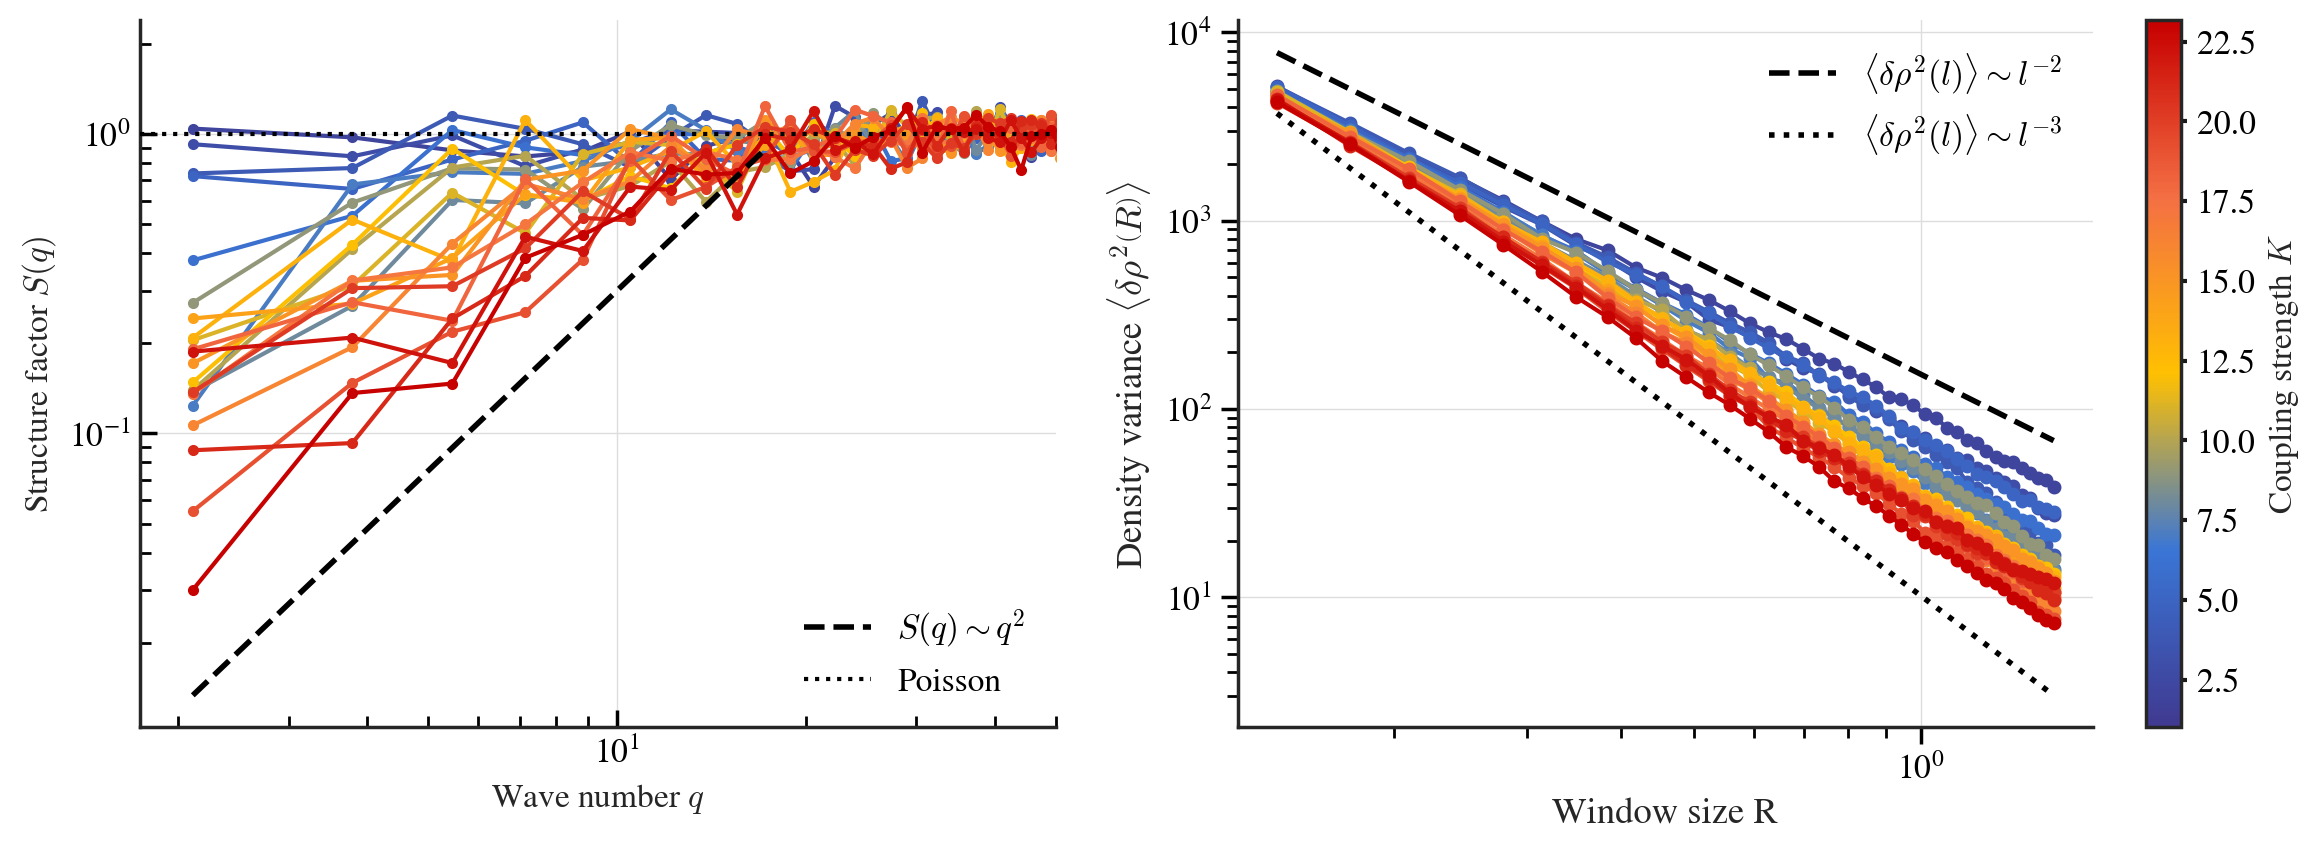

In [23]:
with open(f"temp/Sqs_dict_vary_K_d0_{distanceD0s[0]}.pkl", "rb") as f:
    Sqs_dict = pickle.load(f)

selectedKs = strengthKs[:-15]

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5), width_ratios=[6, 7])
ax1, ax2 = axs

for params, (qs, Sqs) in tqdm(Sqs_dict.items()):
    if params[0] not in selectedKs:
        continue

    qs, Sqs = np.array(qs), np.array(Sqs)

    q_bins = np.linspace(qs.min(), qs.max(), 60)
    Sqs_binned = np.zeros((len(q_bins)-1, 2))
    for i in range(len(q_bins)-1):
        mask = (qs >= q_bins[i]) & (qs < q_bins[i+1])
        if np.any(mask):
            Sqs_binned[i, 0] = np.mean(Sqs[mask])
            Sqs_binned[i, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))

    ax1.plot(
        0.5 * (q_bins[:-1] + q_bins[1:]), Sqs_binned[:, 0],
        marker="o", markersize=3, 
        color=cmap(params[0] / max(selectedKs))
    )

q_values = 0.5 * (q_bins[:-1] + q_bins[1:])[:10]
ax1.plot(q_values, np.array(q_values) ** 2 * 0.003, '--', color="black", 
         markersize=2, linewidth=2, label=r'$S(q) \sim q^{2}$')

ax1.axhline(1, color='black', linestyle=':', label="Poisson", zorder=100)
ax1.legend(loc="lower right", fontsize=12, frameon=False)
ax1.set_xlabel('Wave number $q$', fontsize=12)
ax1.set_ylabel('Structure factor $S(q)$', fontsize=12)
ax1.semilogx()
ax1.semilogy()
ax1.set_xlim(None, 50)
ax1.grid()
ax1.tick_params(which='both', direction="in")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# rho variance plot
system_size = models[0].boundaryLength
num_particles = models[0].agentsNum
l_values = np.linspace(system_size / 50, 1.5, 40)  # 窗口大小 l
rho_0 = num_particles / (system_size**2)

with open(f"temp/variance_rho_dict_vary_K_d0_{distanceD0s[0]}.pkl", "rb") as f:
    variance_rho_dict = pickle.load(f)

for params, (l_values, variance_rho) in variance_rho_dict.items():
    if params[0] not in selectedKs:
        continue
    
    ax2.loglog(l_values, variance_rho, 'o-', markersize=4,
               color=cmap(params[0] / max(selectedKs)))

ax2.loglog(l_values, rho_0 / (l_values**2) * 1.5, '--', lw=2,
           color="black", label=r'$\langle \delta \rho ^2( l ) \rangle \sim l^{-2}$')
ax2.loglog(l_values, rho_0 / (l_values**3) / 10, ':', lw=2,
           color="black", label=r'$\langle \delta \rho ^2( l ) \rangle \sim l^{-3}$')
# 理论线 ⟨δρ²(𝑙)⟩ = ρ₀ / l²

ax2.set_xlabel('Window size R')
ax2.set_ylabel(r'Density variance $\langle \delta \rho ^2\left( R \right) \rangle$')

ax2.grid(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(frameon=False)

norm = plt.Normalize(min(selectedKs), max(selectedKs))
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax2)
cbar1.set_label(r'Coupling strength $K$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

plt.tight_layout()
plt.savefig(f"{LOCAL_FIG_PATH}/Sq_and_rho_vary_K_d0_{distanceD0s[0]}.pdf", bbox_inches='tight')